edited by jerry

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

# load data to train
trainset = torchvision.datasets.CIFAR10(
    root='./data/train',
    train=True,
    download=True,
    transform=transform
)

# load data to test
testset = torchvision.datasets.CIFAR10(
    root = './data/test',
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 170M/170M [00:12<00:00, 13.5MB/s]


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


50000
torch.Size([3, 32, 32]) 6


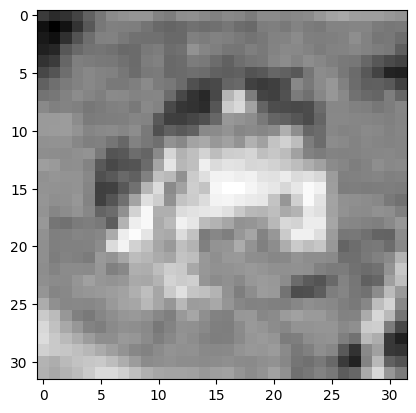

In [3]:
from matplotlib import pyplot as plt

print(len(trainset)) # 50,000
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

10000
torch.Size([3, 32, 32]) 3


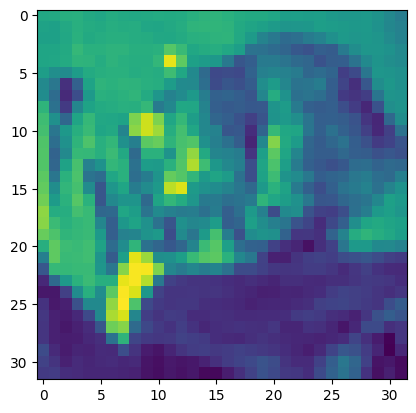

In [4]:
print(len(testset)) # 10,000
print(testset[0][0].shape, testset[0][1])
plt.imshow(testset[0][0][0])

In [5]:
batch_size = 256

# dataloader for trainset
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# dataloader for testset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


1. Ensure Input Data is Float: In the Model class, you are flattening the input tensor x before passing it to the first layer. Make sure this tensor is of type float32. If it's not, convert it explicitly using .type(torch.float32) before flattening.

2. Output Dimension: The output dimension of the final layer (self.layer3) has been changed from 1 to 10 to match the number of classes in the MNIST dataset. This will ensure that the model outputs a probability distribution over the 10 possible digits.

3. Activation Function: The ReLU activation function has been removed from the final layer. This is because nn.CrossEntropyLoss expects raw, unnormalized scores (logits) as input. Removing the activation function allows the model to output these scores directly.

In [7]:
from torch import nn

activation = nn.LeakyReLU()

# CNN model would be better
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # change output dimension to 10 for CFAR10 (10 categories)

    self.act = activation

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # remove activation function from the final layer

    return x


model = Model(32 * 32 * 3, 1024)

In [9]:
class DropoutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.dropout = nn.Dropout(0.1)
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.layer3(x) # dropout not applied

    return x

model = DropoutModel(32 * 32 * 3, 1024)

In [ ]:
# class CNN(nn.Module):
#   def __init__(self, input_dim, n_dim):
#     super().__init__()

#     self.conv1 = nn.Conv2d(3,

In [10]:
# import os

# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [15]:
from torch.optim import SGD, Adam

lr = 0.001
model = model.to('cuda')

#optimizer = SGD(model.parameters(), lr=lr) # adam would be better
optimizer = Adam(model.parameters(), lr=lr)

define loss function

In [16]:
loss_fn = nn.CrossEntropyLoss() # for classification

train and test

In [17]:
n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  train_loss = 0
  train_cnt = 0
  train_acc = 0
  test_cnt = 0
  test_acc = 0

  if not model.training:
    model.train()

  for inputs, labels in trainloader:
    model.zero_grad()
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)

    preds = torch.argmax(preds, dim=1)

    train_cnt += labels.shape[0]
    train_acc += (preds == labels).sum().item()

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_accs.append(train_acc / train_cnt)

  model.eval()
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)

      preds = torch.argmax(preds, dim=1)

      test_cnt += labels.shape[0]
      test_acc += (preds == labels).sum().item()

    test_accs.append(test_acc / test_cnt)

  print(f"Epoch {epoch:3d} | Train Loss: {train_loss}")

Epoch   0 | Train Loss: 381.2073130607605
Epoch   1 | Train Loss: 339.31190943717957
Epoch   2 | Train Loss: 321.97222781181335
Epoch   3 | Train Loss: 311.7455041408539
Epoch   4 | Train Loss: 303.9722237586975
Epoch   5 | Train Loss: 294.57984960079193
Epoch   6 | Train Loss: 288.60834181308746
Epoch   7 | Train Loss: 284.946879863739
Epoch   8 | Train Loss: 280.6032670736313
Epoch   9 | Train Loss: 276.0249810218811
Epoch  10 | Train Loss: 272.4897745847702
Epoch  11 | Train Loss: 267.0852129459381
Epoch  12 | Train Loss: 263.1448253393173
Epoch  13 | Train Loss: 261.77074110507965
Epoch  14 | Train Loss: 257.36930108070374
Epoch  15 | Train Loss: 254.4277160167694
Epoch  16 | Train Loss: 251.3537335395813
Epoch  17 | Train Loss: 249.28333020210266
Epoch  18 | Train Loss: 245.78385996818542
Epoch  19 | Train Loss: 243.00817692279816
Epoch  20 | Train Loss: 239.3665108680725
Epoch  21 | Train Loss: 236.58097553253174
Epoch  22 | Train Loss: 235.0118489265442
Epoch  23 | Train Loss: 2

model accuracy plot

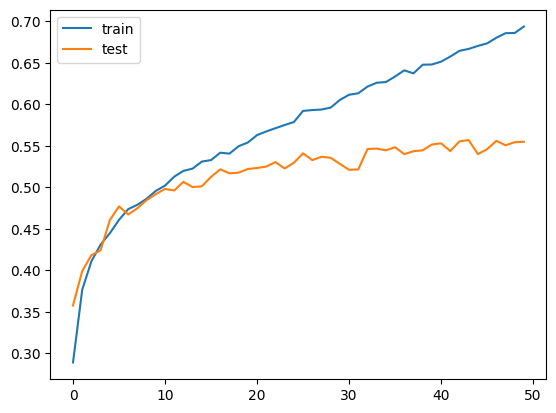

In [18]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accs, test_accs)